# Visualizing simulated data

```bash
# download data
wget "https://www.dropbox.com/s/ub9c6l82ek2yq8q/admix-simu-data.zip?dl=1" -O admix-simu-data.zip?dl=1
unzip admix-simu-data.zip
```

In [1]:
import admix
import numpy as np
import dapgen
import matplotlib.pyplot as plt

In [2]:
# read the simulated dataset
dset = admix.io.read_dataset("admix-simu-data/CEU-YRI")

# Local ancestries

/Users/kangchenghou/work/admix-kit/admix/plot/_plot.py:334: UserWarning: Only the first 10 are plotted. To plot more individuals, increase `max_indiv`
  warnings.warn(
<ipython-input-3-244766047a5b>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


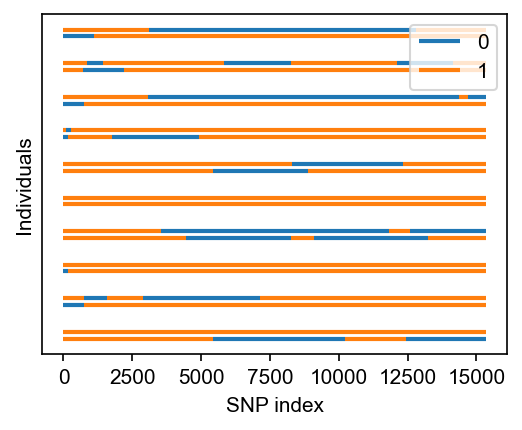

In [3]:
# plot local ancestries for the first 10 individuals
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
admix.plot.lanc(dset=dset)
fig.show()

<ipython-input-4-541886dbb643>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


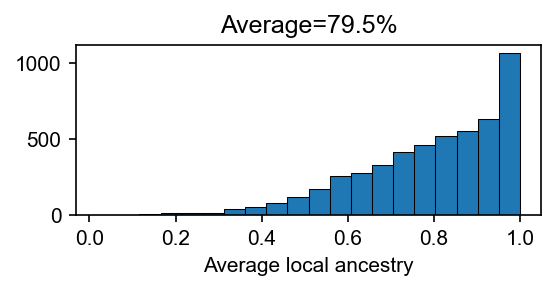

In [4]:
# plot the average local ancestries
lanc = dset.lanc.compute()
avg_lanc = lanc.mean(axis=(0, 2))
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=150)
ax.hist(avg_lanc, bins=20, edgecolor="black", linewidth=0.5)
ax.set_xlabel("Average local ancestry")
ax.set_title(f"Average={avg_lanc.mean() * 100:.1f}%")
fig.show()

# Global ancestries
We first merge the simulated dataset with 1kg

```bash
# joint PCA with 1kg
ref_pfile=1kg-ref-hg38/pgen/all_chr    # path to 1kg pgen file (all chromosomes)
sample_pfile=admix-simu-data/CEU-YRI # path to sample pgen file (all chromosomes)
out_dir=joint-pca    # path to output directory

mkdir -p ${out_dir}
# merge 1kg dataset and sample dataset
admix pfile-merge-indiv \
    --pfile1 ${ref_pfile} \
    --pfile2 ${sample_pfile} \
    --out ${out_dir}/merged

# perform PCA
plink2 --bfile ${out_dir}/merged \
    --pca \
    --out ${out_dir}/merged_pca
```

Then we plot the PCA for this merged data.

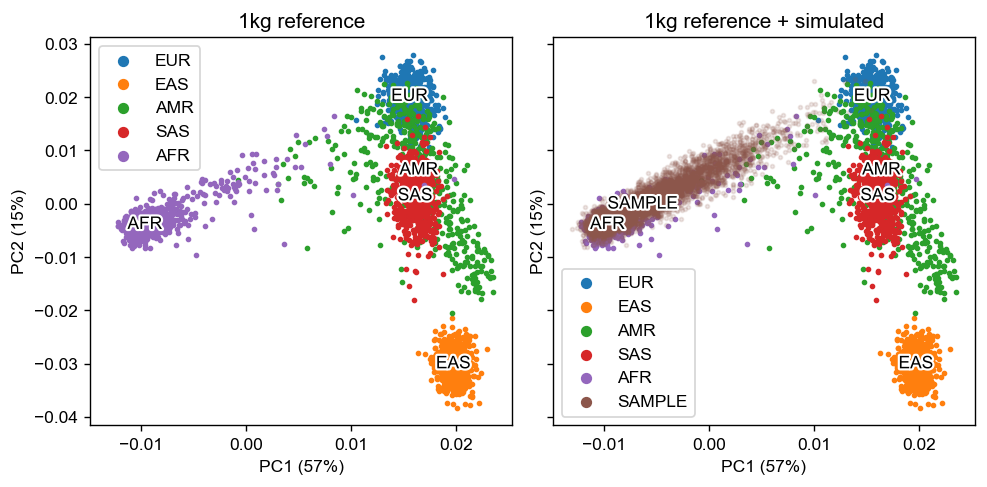

In [5]:
ref_pfile = "1kg-ref-hg38/pgen/all_chr"
pca_prefix = "joint-pca/merged_pca"

df_indiv, eigenval = admix.io.read_joint_pca(ref_pfile=ref_pfile, pca_prefix=pca_prefix)
fig, axes = plt.subplots(figsize=(8, 4), dpi=125, ncols=2, sharex=True, sharey=True)

admix.plot.joint_pca(
    df_pc=df_indiv,
    eigenval=eigenval,
    axes=axes,
    x="PC1",
    y="PC2",
    sample_alpha=0.15,
)
axes[0].set_title("1kg reference")
axes[1].set_title("1kg reference + simulated")

fig.tight_layout()

In [6]:
geno, df_snp, df_indiv2 = dapgen.read_plink("joint-pca/merged.bed")
assert np.all(df_indiv2.IID == df_indiv.index)
# flip SNPs
flip_snps = (df_snp.REF != dset.snp.REF).values
geno[flip_snps, :] = 2 - geno[flip_snps, :]

admix.data.af_per_anc: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


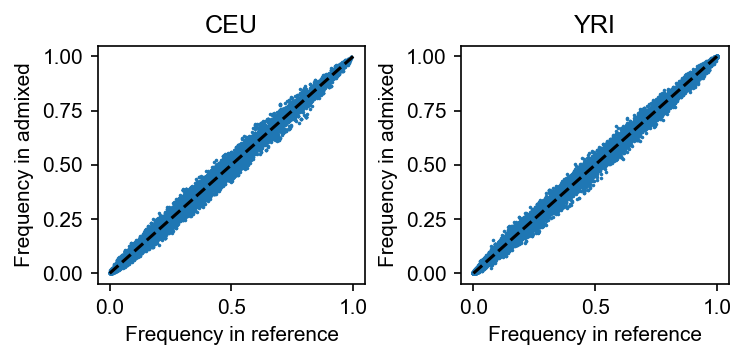

In [7]:
# sanity check for the consistency of frequency calculated in the reference data sets
# and the frequency calculated in the admixed data set
fig, axes = plt.subplots(figsize=(5, 2.5), dpi=150, ncols=2)
for i, anc in enumerate(["CEU", "YRI"]):
    axes[i].scatter(
        geno[:, df_indiv.POP == anc].mean(axis=1) / 2, dset.af_per_anc()[:, i], s=0.5
    )
    axes[i].set_title(anc)
    axes[i].set_xlabel("Frequency in reference")
    axes[i].set_ylabel("Frequency in admixed")
    axes[i].plot([0, 1], [0, 1], "k--")

fig.tight_layout()